In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [95]:
def map_(v,x1,x2,y1,y2):
    ret = (v-x1)/(x2-x1) * (y2-y1) + y1
    return ret

In [96]:
market_mini = 350
market_maxi = 700
gaz_mini = 20
gaz_maxi = 60
inc=10
risque=5
market_nb= (market_maxi-market_mini)/inc
gaz_nb = (gaz_maxi-gaz_mini)/1
#print(spot_nb,eqcp_nb)

In [97]:
market_list = np.array([i for i in range(market_mini,market_maxi,inc)])
gaz_list = np.array([i for i in range(gaz_mini,gaz_maxi,2)])

In [98]:
B_fee = 20
B_Transport = 63
B_gaz = 10.6
F_feeM = 15
F_EUA = 1.3
F_gaz = 11
F_Power = 0.25
F_feeG = 90
F_margin = 125
F_Transport = 52

In [99]:
def get_price_B(market,gaz,FX):
    price_m = market / FX + B_fee + B_Transport
    price_g = gaz * B_gaz + B_fee + B_Transport
    price = max(price_g,price_m)
    return price,price_m,price_g


In [100]:
def get_price_F(market,gaz,FX,EUA, power):
    price_m = market / FX + F_feeM + B_Transport
    price_g = gaz * F_gaz + F_feeG + EUA*F_EUA + power*F_Power + B_Transport
    price_gPlus = price_g + F_margin
    prices = np.array([price_m,price_g,price_gPlus])
    prices = np.sort(prices)
    price = prices[1]
    return price,price_m,price_g,price_gPlus

In [101]:
market = 400
gaz = 28
power = 75
EUA = 80
FX = 1.0905
pB,t,u = get_price_B(market=market, gaz=gaz, FX=FX)
pF,a,b,c = get_price_F(market=market, gaz=gaz, FX=FX,EUA=EUA, power=power)
print(int(pB-pF),pB,t,u, pF,a,b,c)

-133 449.80421824850987 449.80421824850987 379.8 583.75 444.80421824850987 583.75 708.75


In [102]:
# Génération de la matrice [Market x Gaz]
df = pd.DataFrame(columns=market_list)
dfColor = pd.DataFrame(columns=market_list)
for market in market_list:
    pdS = pd.Series()
    pdSColor = pd.Series()
    for gaz in gaz_list:
        pB,_,_ = get_price_B(market=market, gaz=gaz, FX=FX)
        pF,_,_,_ = get_price_F(market=market, gaz=gaz, FX=FX,EUA=EUA, power=power)
        pdS[gaz] = int(pB-pF)
        pdSColor[gaz] = np.random.randint(-100,100)
    df[market] = pdS
    dfColor[market] = pdSColor
#df

In [103]:
np.random.randint(-100,100)

-28

In [104]:
df

,350,360,370,380,390,400,410,420,430,440,...,600,610,620,630,640,650,660,670,680,690
20,-91,-82,-73,-64,-55,-45,-36,-27,-18,-9,...,12,21,30,39,49,58,67,76,85,94
22,-113,-104,-95,-86,-77,-67,-58,-49,-40,-31,...,5,5,8,17,27,36,45,54,63,72
24,-135,-126,-117,-108,-99,-89,-80,-71,-62,-53,...,5,5,5,5,5,14,23,32,41,50
26,-157,-148,-139,-130,-121,-111,-102,-93,-84,-75,...,5,5,5,5,5,5,5,10,19,28
28,-179,-170,-161,-152,-143,-133,-124,-115,-106,-97,...,5,5,5,5,5,5,5,5,5,6
30,-201,-192,-183,-174,-165,-155,-146,-137,-128,-119,...,5,5,5,5,5,5,5,5,5,5
32,-205,-205,-205,-196,-187,-177,-168,-159,-150,-141,...,5,5,5,5,5,5,5,5,5,5
34,-206,-206,-206,-206,-206,-199,-190,-181,-172,-163,...,-16,-7,1,5,5,5,5,5,5,5
36,-207,-207,-207,-207,-207,-207,-207,-203,-194,-185,...,-38,-29,-20,-11,-1,5,5,5,5,5
38,-207,-207,-207,-207,-207,-207,-207,-207,-207,-207,...,-60,-51,-42,-33,-23,-14,-5,3,5,5


In [105]:
#y_ = pd.Series()
#for x_ in market_list:
#    vx= map_(x_*0.65,eqcp_mini,eqcp_maxi,0,eqcp_nb-1)
#    vy = map_(vx,spot_nb-1, 0,spot_mini,spot_maxi)
#    y_[vx] = vy
#print(y_)


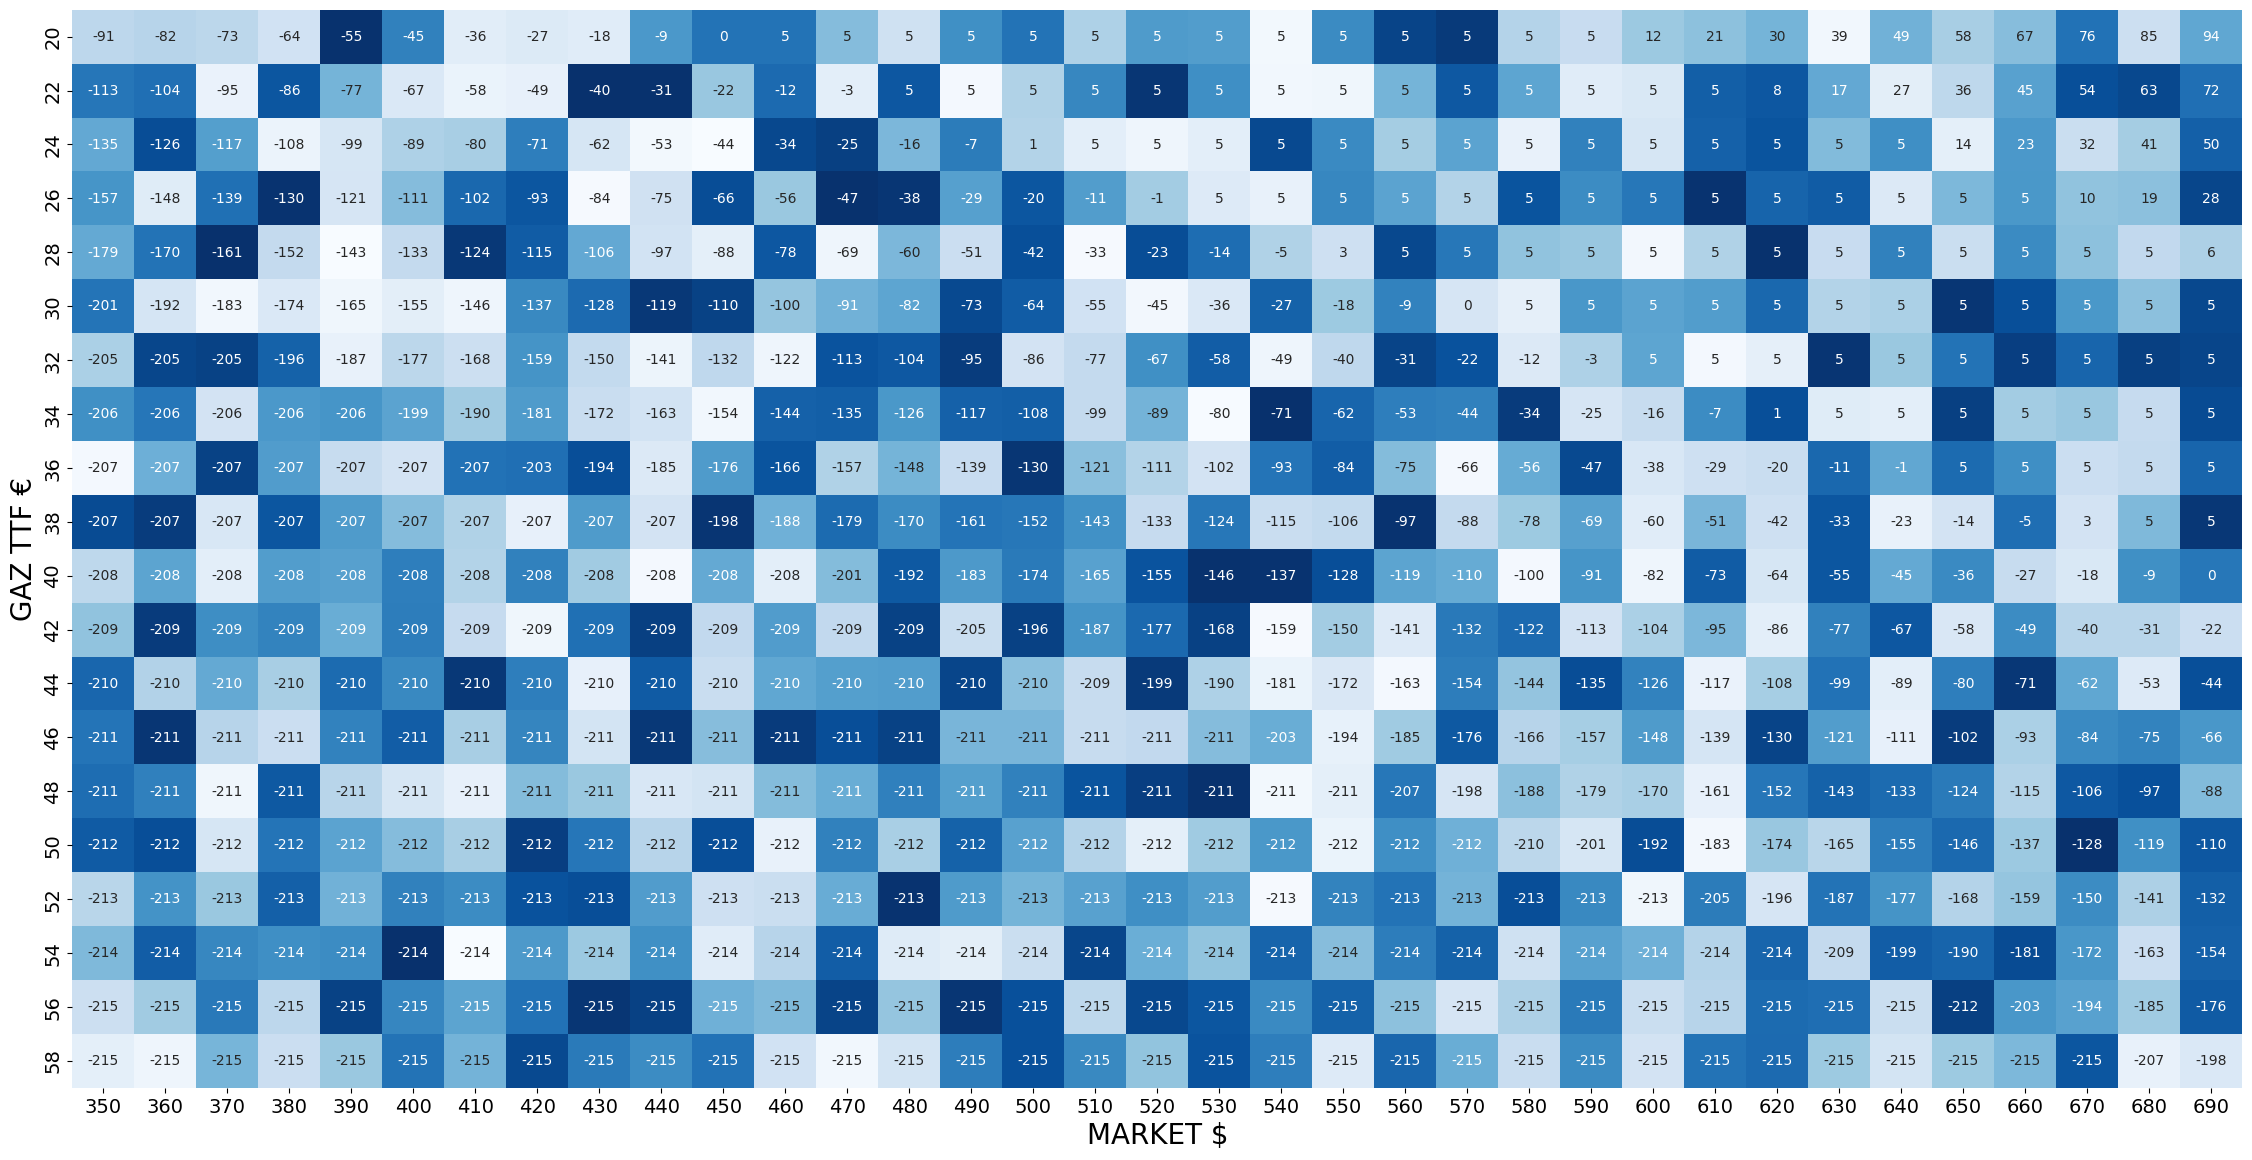

In [106]:
fig,ax = plt.subplots(figsize=(28,14))
# sns.set_palette("Paired")
plt.tick_params(bottom='on')
g = sns.heatmap(dfColor.values,annot=df,xticklabels=market_list, yticklabels=gaz_list, cmap='Blues' , vmin=-100, vmax=100,cbar=False, fmt='d', linecolor='grey' );
# ax2 = plt.twinx()
# g = sns.heatmap(df.values,annot=True,xticklabels=market_list, yticklabels=gaz_list, linewidth=1.5 ,cmap='PiYG', vmin=-50, vmax=5,cbar=False, fmt='d');
# g = sns.heatmap(df.values,annot=True, annot_kws={"size":14},xticklabels=market_list, yticklabels=gaz_list, linewidth=1.5, cmap=['White'] , vmin=-50, vmax=5,cbar=False, fmt='d', linecolor='grey' , ax=ax2);
# im = ax.imshow(df ,cmap='PiYG', vmin=-15, vmax=15, aspect='auto');
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
g.set_xlabel('MARKET $',fontsize=20);
g.set_ylabel('GAZ TTF €',fontsize=20);
#x_ = (eqcp_list-eqcp_mini)/5
# y_ = (x_.max()-x_)*0.7
#sns.lineplot(x=x_, y=y_, linewidth=5, ax=ax2);
# ax.plot(eqcp_list*0.7, linewidth=50);
# ax2.axis('tight')


In [107]:
545*0.65

354.25

In [108]:
geyser = sns.load_dataset("geyser")
geyser

,duration,waiting,kind
0,3.600,79,long
1,1.800,54,short
2,3.333,74,long
3,2.283,62,short
4,4.533,85,long
...,...,...,...
267,4.117,81,long
268,2.150,46,short
269,4.417,90,long
270,1.817,46,short


In [109]:
fig = plt.figure(figsize=(28,15))
sns.set_palette("Paired")
graphe2 = sns.displot(data=df, x=df[200], y=df[350], kind='kde');


KeyError: 200

<Figure size 2800x1500 with 0 Axes>